## **Bird Classification**

In [ ]:
import os
import numpy             as np
import matplotlib.pyplot as plt

#from google.colab import drive
import tensorflow        as tf
from matplotlib.pyplot import imshow

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import time
import datetime
import zoneinfo
zona_hermosillo = zoneinfo.ZoneInfo("America/Hermosillo")
t = time.time()

### Reading dataset from Kaggle

The dataset contains 89,895 bird images from 525 different species.

It can be found here: https://drive.google.com/file/d/1R-N7awUIuL5eNth8fqRKAV6B5Dc5Aof9/view?usp=sharing

In [ ]:
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install unzip

  Preparing metadata (setup.py) ... done
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1281 sha256=336a945a9f5d66e2ea95646bef752636b2c6475e1f5105b9ec762e065cfea712
  Stored in directory: /root/.cache/pip/wheels/fb/5b/81/0f3e1e533b52883f88ab978178c15627a4fce4c13f74911dce
Successfully built unzip


In [ ]:
!mkdir '/Dataset'

In [ ]:
!unzip 'archive.zip' -d '/Dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /Dataset/train/WHITE TAILED TROPIC/120.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/121.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/122.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/123.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/124.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/125.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/126.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/127.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/128.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/129.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/130.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/131.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/132.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/133.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/134.jpg  
  inflating: /Dataset/train/WHITE TAILED TROPIC/135.jpg  
  inflating: /Dataset

In [ ]:
train_directory       = '/Dataset/train'
test_directory       = '/Dataset/test'
valid_directory       = '/Dataset/valid'


In [ ]:
train_datagenerator   = ImageDataGenerator( rescale=1/255. )
val_datagenerator   = ImageDataGenerator( rescale=1/255. )
test_datagenerator   = ImageDataGenerator( rescale=1/255. )


In [ ]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
train_dataset = train_datagenerator.flow_from_directory(train_directory,
                                                         target_size = IMG_SIZE,
                                                         batch_size = 32,
                                                         shuffle = True,
                                                         class_mode = "categorical",
                                                         color_mode='rgb')

val_dataset = val_datagenerator.flow_from_directory(valid_directory,
                                                         target_size = IMG_SIZE,
                                                         batch_size = 32,
                                                         shuffle = False,
                                                         class_mode = "categorical",
                                                         color_mode='rgb')

test_dataset = test_datagenerator.flow_from_directory(test_directory,
                                                         target_size = IMG_SIZE,
                                                         batch_size = 32,
                                                         shuffle = False,
                                                         class_mode = "categorical",
                                                         color_mode='rgb')

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [ ]:
class_names = list(train_dataset.class_indices.keys())

In [ ]:
class_names[0]

'ABBOTTS BABBLER'

In [ ]:
import random
from PIL import Image

# One image from each class
pics = []
labels = [x for x in train_dataset.class_indices]

for i in range( len(labels) ):
  nombre_imagen_aleatoria = random.choice(os.listdir( train_directory +'/'+ class_names[i] ) )
  path = train_directory + '/' + class_names[i] + "/" + nombre_imagen_aleatoria
  pics.append( (path, class_names[i]) )

In [ ]:
plt.figure(figsize = (16,500))
i=0
for image, label in pics:
  img = Image.open(image)
  plt.subplot(150,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(True)
  plt.imshow(img)
  plt.xlabel( '('+str(i) + ') ' + label,fontsize = 10)
  i+=1
plt.show()


### Transfer learning

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
x, y = next(iter(train_dataset))
print(x.shape)

(32, 224, 224, 3)


In [ ]:
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Freeze some layers so they are not trained again.

In [ ]:
base_model.trainable = True

# Freeze the first ~120 layers
for layer in base_model.layers[:120]:
    layer.trainable = False


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
drop_layer = tf.keras.layers.Dropout(0.2)
dense_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')

model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    drop_layer,
    dense_layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 525)               672525    
                                                                 
Total params: 2,930,509
Trainable params: 2,297,421
Non-trainable params: 633,088
_________________________________________________________________


In [ ]:
from keras import optimizers
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

In [ ]:
import datetime
import zoneinfo
zona_hermosillo = zoneinfo.ZoneInfo("America/Hermosillo")
hora_hermosillo = datetime.datetime.now(zona_hermosillo)
print(f'En Hermosillo, son las {hora_hermosillo.hour:2}:{hora_hermosillo.minute:2}:{hora_hermosillo.second:2} hrs')

En Hermosillo, son las 18:51: 1 hrs


In [ ]:
epochs = 5

%time history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/5


2645/2645 [==============================] - 605s 229ms/step - loss: 1.2338 - accuracy: 0.7502 - val_loss: 0.5679 - val_accuracy: 0.8762
Epoch 2/5
2645/2645 [==============================] - 598s 226ms/step - loss: 0.4573 - accuracy: 0.8959 - val_loss: 0.3180 - val_accuracy: 0.9192
Epoch 3/5
2645/2645 [==============================] - 546s 206ms/step - loss: 0.2635 - accuracy: 0.9402 - val_loss: 0.2555 - val_accuracy: 0.9360
Epoch 4/5
2645/2645 [==============================] - 514s 194ms/step - loss: 0.1619 - accuracy: 0.9638 - val_loss: 0.2178 - val_accuracy: 0.9421
Epoch 5/5
2645/2645 [==============================] - 511s 193ms/step - loss: 0.1049 - accuracy: 0.9773 - val_loss: 0.2070 - val_accuracy: 0.9429
CPU times: user 3h 28min 21s, sys: 4min 47s, total: 3h 33min 9s
Wall time: 46min 14s


In [ ]:
model.save("model-mobilenet2.keras")

import subprocess

# Export to TensorFlow.js
try:
    import tensorflowjs
except ImportError:
    subprocess.run(["pip", "install", "tensorflowjs"])

os.makedirs("model-mobilenet2", exist_ok=True)


subprocess.run([
    "tensorflowjs_converter",
    "--input_format", "keras",
    "model-mobilenet2.keras",
    "model-mobilenet2"
])

INFO:tensorflow:Assets written to: saved_model-mobilenet/assets


INFO:tensorflow:Assets written to: saved_model-mobilenet/assets
2025-11-23 22:06:56.546420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-23 22:06:56.638290: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 22:06:56.641160: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lo

CompletedProcess(args=['tensorflowjs_converter', '--input_format', 'keras', 'model-mobilenet.keras', 'model-mobilenet'], returncode=0)

### Plots

In [ ]:
acc =  [0.] + history.history['accuracy']
val_acc =  [0.] + history.history['val_accuracy']

loss = [ np.max(history.history['loss']) ] + history.history['loss']
val_loss = [ np.max(history.history['val_loss']) ] + history.history['val_loss']

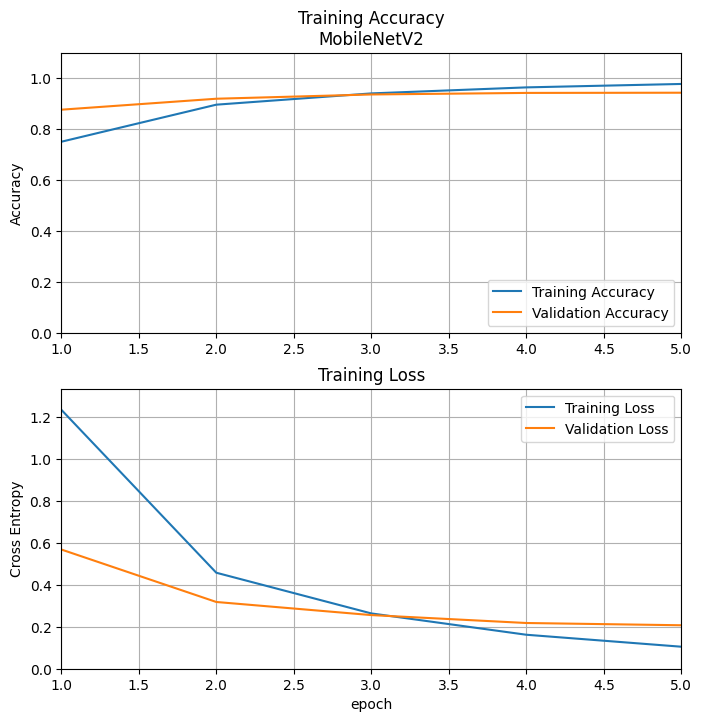

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlim([1,epochs])
plt.ylim([0,1.1])
plt.grid(True)
plt.title('Training Accuracy\nMobileNetV2')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlim([1,epochs])
max1 = np.max(loss)
max2 = np.max(val_loss)
plt.ylim([0, np.max([max1,max2])+0.1 ])
plt.grid(True)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(test_dataset)

83/83 [==============================] - 10s 120ms/step - loss: 0.1325 - accuracy: 0.9665


[0.13245034217834473, 0.9664762020111084]

Acurracy of 96.64% with test data!